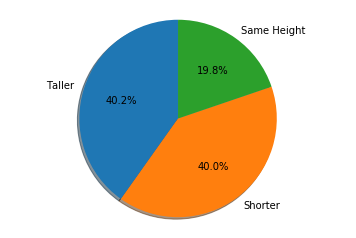

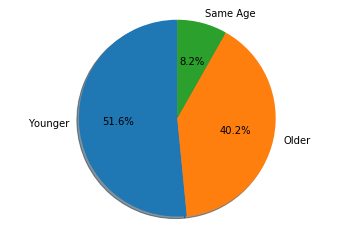

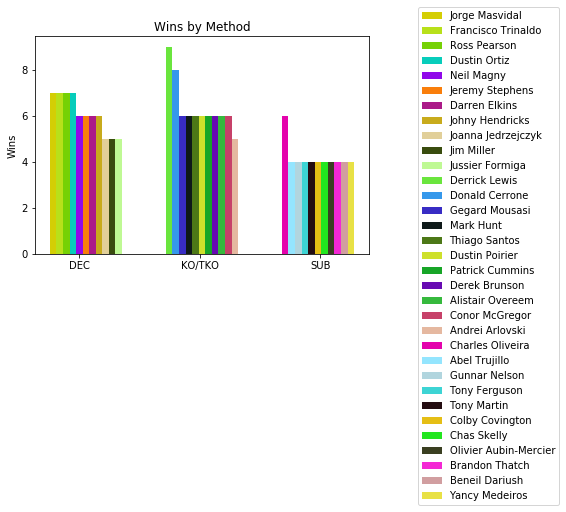

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import random


class UFCData(object):
    '''
    Class for parsing and performing calculations on the UFC data set
    '''
    
    def __init__(self, filename):
        self.ufc_data = pd.read_csv(filename)
        self.win_types = {}   
    
    @property
    def ufc_data(self):
        '''
        Property for ufc_data
        @return: the instance's pandas Dataframe        
        '''
        
        return self._ufc_data
    
    @ufc_data.setter
    def ufc_data(self, data):
        '''
        This setter method will drop unneeded columns from the data set
        @param data: A pandas Dataframe from a read-in csv file
        @type data: pandas.Dataframe
        '''
        
        # List of known named columns that must be dropped. Some fight round columns will be dropped later
        columns_to_drop = ['Date', 'Event_ID', 'Last_round', 'Max_round', 'RStreak', 'HomeTown', 'Location', 'Weight']
        
        # Drop afformentioned columns
        data = data.drop(columns=columns_to_drop)

        # Now we have many columns of round data. The only columns that we want to keep are either strikes landed or submissions
        # landed. Which means we have to drop every column that doesn't have a label which matches this pattern:
        # 'Round * _Landed'
        for i in data.columns.values:
            # Check if this is a Round columnn:
            if i.startswith('Round'):
                # If the column describes a landed technique, keep it. Otherwise drop it
                if i.endswith('Landed'):
                    pass

                else:
                    data = data.drop(i, axis=1)

        # To simplyfy the data set further, I'm only keeping the 'Round N Total Strikes Landed' columns
        for i in data.columns.values:
            # Check if this is a strikes column
            if 'Strikes' in i:
                # If this is the total strikes landed column, keep it. Otherwise drop it
                if i.endswith('_Strikes_Total Strikes_Landed'):
                    pass

                else:
                    data = data.drop(i, axis=1)

        # Since I'm also comparing wins and losses, I will have to remove the 'draw' and 'no contest' fights to simplify things
        for index, row in data.iterrows():
            # Check if fight is a draw or no contest, if so remove the record
            if row.loc['winner'] == 'draw' or row.loc['winner'] == 'no contest':
                data = data.drop(index)
        
        # Set the trimmed data set to the main data
        self._ufc_data = data
        
    def get_all_fighters_by_win_type(self):
        '''
        Gets all fighters by win type in a key-value map, where the key is the fighters name, and the value is 
        a tuple of three numbers representing their wins by decision, ko/tko, and submission
        @return: A key value dict of fighter name, and win total type tuple.
        '''
        
        # Get the most wins, including id, name, and win type
        wins_series = self.ufc_data[["Name", "winby"]].groupby(["Name", "winby"]).size()

        # Loop through data and create dictionary mapping
        for record in wins_series.iteritems():        
            # First item is a tuple with name and win type
            win_type = record[0][1]
            # Get win type listings, for some reason there are 0s in the data
            if win_type != '0':
                # Get the wins type dict for this win type, or create a new one
                self.win_types[win_type] = self.win_types.get(win_type, {})
                # Name is in the first item of the tuple
                name = record[0][0]
                # Get the current wins (or set to 0) then increment
                self.win_types[win_type][name] = self.win_types[win_type].get(name, 0)
                self.win_types[win_type][name] = self.win_types[win_type][name] + record[1]
        
        # Convert each of the win types to a Series, and get top 10 in each category.
        for win_type in self.win_types:
            # Convert to series.
            series = pd.Series(self.win_types[win_type])
            # Sort and get top ten entries.
            self.win_types[win_type] = series.sort_values(ascending=False)[:11]
    
        # This data needs to be moved around before it can be plotted
        # Create a new mapping of fighter names : list. This is for plotting in the bar graph.
        all_fighters = {}

        for key in self.win_types.keys():
            for fighter_record in self.win_types[key].iteritems():        
                # Fighter name is first item in the tuple.
                name = fighter_record[0] 
                # Set name and an empty array of 0s for this fighter.
                all_fighters[fighter_record[0]] = np.zeros(3)

        # Add win typer entries for each fighter to their array.
        # This is because the bar chart needs equally shaped arrays
        # For each fighter even if the entry for a win type is 0.
        for fighter in all_fighters:
            # Index for tracking placement in fighter win type array
            index = 0
    
            for key in self.win_types.keys():       
                # Keep track of wether the fighters name was found in the win type
                # object. It may not be, then if not, there needs to be a 0 entry added for that win type
                # in the fighters win types array.
                found = False       
        
                for item in self.win_types[key].iteritems():
                    # Item is a tuple that looks like ("Name", "# of wins")
                    fighter_name = item[0] 
                    fighter_wins = item[1]
                    # Record of this currently iterated fighter found, add it to their win types array
                    # and mark as found.
                    if fighter == item[0]:
                        all_fighters[fighter][index] = item[1]
                        found = True
        
                index += 1       
        
        return all_fighters
    
    def columns(func):
        '''
        Wrapper function to get all the columns index locations. 
        This is for convenience when using the get winners and get_losers functions
        @param func: The function to wrap
        @type func: a function
        @return: wrapper function
        '''
        
        def func_wrapper(self):
            # Get column numbers for height and age
            height_col = ufc_data.columns.get_loc('Height')
            age_col = ufc_data.columns.get_loc('Age')
            fight_id_col = ufc_data.columns.get_loc('Fight_ID')
            corner_col = ufc_data.columns.get_loc('corner')
            winner_col = ufc_data.columns.get_loc('winner')
            
            return func(self)
        return func_wrapper
    
    @columns    
    def get_winners(self):
        '''
        Creates an array of all of the winners in the data set
        @return: a Numpy array of all the winners in the data set
        '''
        
        # Create numpy array for winners
        ufc_np_arr = np.array(ufc_data)
        # Sort the array by Fight ID
        ufc_np_arr = np.array(sorted(ufc_np_arr, key=lambda x: x[fight_id_col]))
        # Make boolean indexed array for fight winners
        winners_idx = (ufc_np_arr[:, corner_col] == ufc_np_arr[:, winner_col])
        np_winners = ufc_np_arr[winners_idx]
        return np_winners
    
    @columns    
    def get_losers(self):
        '''
        Creates an array of all of the losers in the data set
        @return: a Numpy array of all the losers in the data set
        '''
        
        # Create numpy array for  losers
        ufc_np_arr = np.array(ufc_data)
        # Sort the array by Fight ID
        ufc_np_arr = np.array(sorted(ufc_np_arr, key=lambda x: x[fight_id_col]))        
        # Make a boolean index array of fight losers
        losers_idx = (ufc_np_arr[:, corner_col] != ufc_np_arr[:, winner_col])
        np_losers = ufc_np_arr[losers_idx]
        return np_losers
        
    def get_height_totals(self):
        '''
        Gets the total number of winners who were taller, shorter, and the same height
        @return: a tuple of taller winners, shorter, winnners, same height winners
        '''
        # Get the fight winners and losers
        np_winners = self.get_winners()
        np_losers = self.get_losers()
        
        # To make iterations clearer
        num_fights = len(np_winners)

        # Tally totals for height difference in winners
        taller_total = 0
        shorter_total = 0

        # Get totals for winners by height
        for i in range(0, num_fights):
            if np_winners[i][height_col] > np_losers[i][height_col]:
                taller_total += 1

            elif np_winners[i][height_col] < np_losers[i][height_col]:    
                shorter_total +=1            

        # Calculate the rest as same heightS
        same_height = len(np_winners) - (taller_total + shorter_total)        
      
        return taller_total, shorter_total, same_height
    
    def get_age_totals(self):
        '''
        Gets the total number of winners who were younger, older, and the same age
        @return: a tuple of younger winners, older winners, and same age winners
        '''
        
        # Get winners and losers
        np_winners = self.get_winners()
        np_losers = self.get_losers()
        
        # To make iterations clearer
        num_fights = len(np_winners)
        
        # Tally totals for age difference in winners
        younger_total = 0
        older_total = 0
        
        # Get totals for winners by age
        for i in range(0, num_fights):
            if np_winners[i][age_col] < np_losers[i][age_col]:
                younger_total += 1

            elif np_winners[i][age_col] > np_losers[i][age_col]:
                older_total += 1
        
        # Calculate the rest as same age
        same_age = len(np_winners) - (younger_total + older_total)    
        
        return younger_total, older_total, same_age
    
    
class UFCDataCharts(object):
    '''
    Class for creating charts out of the UFC data set
    '''
    
    def __init__(self):
        pass
    
    @staticmethod
    def _random_color():
        '''
        Creates a random color value as a decimal and returns it
        @return: a float of a random color value
        '''
        
        return int(random.random() * 256) / 256
    
    @classmethod
    def get_rgb(cls):
        '''
        Creates and returns an rgb color tuple
        @return: a tuple of three float color values
        '''
        
        return (cls._random_color(), cls._random_color(), cls._random_color())
    
    def pie_chart(self, labels, totals):
        '''
        Draws a pie chart
        @param labels: The labels for the pie chart
        @type labels: list of strings
        @param totals: totals to add to the pie chart
        @type totals: list of ints (to be converted to percentages)        
        '''
        
        # Convert the  totals into percentages
        percentages = [((x / np.sum(totals)) * 100) for x in totals]
        # Create the figure and axis to plot
        fig, ax = plt.subplots()
        # create the pie chart, add labels and 
        ax.pie(percentages, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        # Set axis as equal
        ax.axis('equal')
        # Show the chart
        plt.show()
    
    def bar_chart(self, data_map, xlabels, ylabel, title, width=.15):
        '''
        Create a bar chart
        @param data_map: The map of data to display in mutiple grouped bar charts
        @type data_map: dict consiting of a key-value pair. Value is a tuple
        @param xlabels: labels for the x axis
        @type xlabels: list of strings
        @param ylabel: y axis label
        @type ylabel: string
        @param title: The title of the chart
        @type title: string
        @param width: the width multiplier of each bar
        @type width: float
        '''
        
        # Use matplotlib to create a bar graph with the xlabel categories            
        ind = np.arange(len(xlabels))  
         
        # Space between bars to be incremented
        space = 0

        fig, ax = plt.subplots()
        # Loop through all the data and create bar sets for them
        for data in data_map: 
            # Increment the space on x to set a bar
            space += width
            # Create a bar set for the fighter
            bars = ax.bar(ind + space, data_map[data], width, color=UFCDataCharts.get_rgb(), label=data) 

        # Add some text for labels, title.
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        #Set the x ticks positions, have to do this statically for now
        xticks = [.75, 3.5, 6.25]
        ax.set_xticks(xticks)
        # Set the xticks labels
        xticklabels = [xlabel for xlabel in xlabels]                      
        ax.set_xticklabels(xticklabels)
        # Move the legend, otherwise it will overlap the graph
        ax.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
        # Show / print the graph
        plt.show()

        
# Our csv file to be read in        
file = 'UFC_Rounds.csv'
# New instance of UFCData to create and parse data
ud = UFCData(file)
# All fighters and their win types mapping
all_fighters = ud.get_all_fighters_by_win_type()
# Win types for a match
win_types = ud.win_types
# Totals of winners by height data
taller_total, shorter_total, same_height = ud.get_height_totals()
# Totals of winners by age data
younger_total, older_total, same_age = ud.get_age_totals()
# New data charts
udc = UFCDataCharts()
# Pie chart for height data
udc.pie_chart(['Taller', 'Shorter', 'Same Height'], [taller_total, shorter_total, same_height])
# Pie chart for age data
udc.pie_chart(['Younger', 'Older', 'Same Age'], [younger_total, older_total, same_age])
# Bar chart for fighters and their win type
udc.bar_chart(all_fighters, win_types.keys(), 'Wins', 'Wins by Method', .15)
